In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['font.family'] = 'Arial'

In [3]:
import os
import sys

src_dir = './../../src/'
sys.path[0] = src_dir

import matplotlib.pyplot as plt

import glob

import numpy as np
import pandas as pd
import seaborn as sns

from collections import OrderedDict

from access_biology_data import meta, relations, properties
from access_literature_data import medline
from access_science_shared import standardizer 

In [4]:
sys.path.append('./../src/')
from aging_tools import inout, export
from access_aging_data import earlier_studies, chaperome, companions, sequencing

from access_science_shared import standardizer

In [5]:
from narrative import nar181026_heat_confidence_genes
from narrative import nar181205_networks

In [6]:
from scipy.stats import mannwhitneyu
from scipy.stats import spearmanr

In [7]:
save_images = True

In [8]:
outfolder = '191030_transcript_length_tilting_high_reproducibility_samples'

In [9]:
ref_genes = standardizer.reference_genes(10090, 'orp')

In [10]:
def get_reproducibility():

    all_de, detection, mice_in_comparisons, triplicate_series = nar181026_heat_confidence_genes.load_detection(
        detection_column='padj')

    tissues_to_consider = ['BAT', 'Blood', 'GutEP', 'MuscSat', 'Adrenal', 'Kidney',
           'Heart', 'Liver', 'Skin', 'Stomach', 'Brain', 'SI',
           'LI', 'Cerebellum', 'WAT', 'Esophagus', 'Lung'] 
    pfus=[0]

    first = all_de[
        (all_de['younger'] == 4) & 
        (all_de['is_detected'] == True) &
        (all_de['de_unit'] == 'first') &
        (all_de['tissue'].isin(tissues_to_consider)) &
        (all_de['pfu'].isin(pfus)) & 
        (all_de['gene_ncbi'].isin(ref_genes))
    ]

    second = all_de[
        (all_de['younger'] == 4) & 
        (all_de['is_detected'] == True) &
        (all_de['de_unit'] == 'second') &
        (all_de['tissue'].isin(tissues_to_consider)) &
        (all_de['pfu'].isin(pfus)) & 
        (all_de['gene_ncbi'].isin(ref_genes))
    ]


    ages = [9, 12, 18, 24]

    out = pd.DataFrame(index=tissues_to_consider, columns=ages)

    agg = []

    for tissue in tissues_to_consider:
        for age in ages:
            fi = first[
                (first['older']==age) & 
                (first['tissue']==tissue)            
            ][['gene_ncbi', 'o_over_y']]


            se = second[
                (second['older']==age) & 
                (second['tissue']==tissue)          
            ][['gene_ncbi', 'o_over_y']]

            m =pd.merge(fi, se, on='gene_ncbi', how='inner', suffixes=('_fi', '_se'))

            di = dict()
            di['tissue'] = tissue
            di['age'] = age
            di['rho'] = spearmanr(m['o_over_y_fi'], m['o_over_y_se'])[0]
            agg.append(di)

    o = pd.DataFrame(agg)
    h = o.pivot(index='tissue', columns='age', values='rho')
    
    

    return first, second, o, h

first, second, rep_o, rep_h = get_reproducibility()

In [11]:
rep_h.head()

age,9,12,18,24
tissue,,,,
Adrenal,0.107905,-0.027938,0.360199,0.344594
BAT,-0.255230,0.171381,0.163043,0.237920
Blood,0.001193,-0.230496,0.163063,0.460072
Brain,0.001313,-0.441334,0.021220,-0.140836
Cerebellum,0.871107,-0.071962,-0.019640,0.101056


In [12]:
rep_o.head()

,age,rho,tissue
0,9,-0.255230,BAT
1,12,0.171381,BAT
2,18,0.163043,BAT
3,24,0.237920,BAT
4,9,0.001193,Blood


In [13]:
all_de, detection, mice_in_comparisons, triplicate_series = nar181026_heat_confidence_genes.load_detection(
    detection_column='padj')


tissues_to_consider = ['BAT', 'Blood', 'GutEP', 'MuscSat', 'Adrenal', 'Kidney',
       'Heart', 'Liver', 'Skin', 'Stomach', 'Brain', 'SI',
       'LI', 'Cerebellum', 'WAT', 'Esophagus', 'Lung'] 

all_de = all_de[
    (all_de['tissue'].isin(tissues_to_consider)) & 
    (all_de['pfu']==0) &
    (all_de['gene_ncbi'].isin(ref_genes))

]


In [14]:
from scipy.stats import spearmanr

In [15]:
from natsort import natsorted

In [16]:
conditions = natsorted(all_de['condition'].unique())

In [17]:
out = pd.DataFrame(index=conditions, columns=[
    'corr', 'pval'
]).rename_axis('condition')

In [18]:
pr = properties.genbank_validated_rna(10090)[['gene_ncbi', 'Genbank_validated_RNA: full_SumACGT']].rename(columns={
    'Genbank_validated_RNA: full_SumACGT': 'length'
})

pr.loc[:, 'log_length'] = np.log10(pr['length'])

In [19]:
%%time

for condition in conditions:
    d = all_de[
        (all_de['de_unit']=='both') & (all_de['condition']==condition)
    ]

    d = d[['gene_ncbi', 'o_over_y', 'log_padj', 'log_pvalue']].dropna()
    d = pd.merge(d, pr)

    r, p = spearmanr(d['log_length'], d['o_over_y'])
    d = d.set_index('gene_ncbi')

    out.loc[condition, 'corr'] = r
    out.loc[condition, 'pval'] = p

CPU times: user 3min 25s, sys: 3.94 s, total: 3min 29s
Wall time: 1min 39s


In [20]:
safe = out.copy()

In [21]:
out = safe.copy()

In [22]:
# out = out.dropna()

In [23]:
out = out.reset_index()

In [24]:
out = pd.merge(out, all_de[['condition', 'younger', 'older']].drop_duplicates())

In [25]:
out = out[out['younger']==4]

In [26]:
out = pd.merge(
    out,
    all_de[['condition', 'tissue', 'younger', 'older']].drop_duplicates()
)

In [27]:
rep_o[rep_o['rho']>0.2].rename(columns={'age': 'older'})

,older,rho,tissue
3,24,0.237920,BAT
7,24,0.460072,Blood
11,24,0.220164,GutEP
18,18,0.360199,Adrenal
19,24,0.344594,Adrenal
20,9,0.704399,Kidney
23,24,0.538482,Kidney
24,9,0.751957,Heart
31,24,0.208463,Liver
37,12,0.399101,Stomach


In [28]:
out = pd.merge(
    out,
    rep_o[rep_o['rho']>0.2].rename(columns={'age': 'older'})
)

In [29]:

if save_images:
    export.export_full_frame(
        '{}/stats_on_imbalance.xlsx'.format(outfolder),
        out, 
        save_index=False)

In [30]:
out.head()

,condition,corr,pval,younger,older,tissue,rho
0,Adrenal_0_4_18,0.0600566,1.6534e-09,4.0,18.0,Adrenal,0.360199
1,Adrenal_0_4_24,-0.162002,1.07144e-58,4.0,24.0,Adrenal,0.344594
2,BAT_0_4_24,-0.334887,1.30268e-218,4.0,24.0,BAT,0.237920
3,Blood_0_4_24,-0.646453,3.79871e-95,4.0,24.0,Blood,0.460072
4,Cerebellum_0_4_9,-0.337097,0,4.0,9.0,Cerebellum,0.871107


In [34]:
u = out.copy()

In [35]:
u['older'] = u['older'].astype(float)
u['corr'] = u['corr'].astype(float)

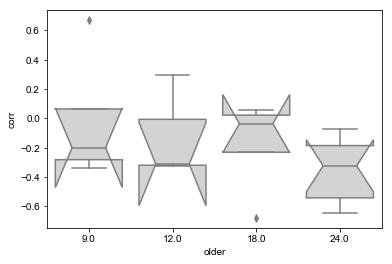

In [36]:
sns.boxplot(x='older', y='corr', data=u, notch=True, color='lightgrey')
if save_images:
    export.export_image('{}/box_any_age_to_older.pdf'.format(outfolder))

In [37]:
u[(u['younger']==4) & (u['older']==18)].sort_values('corr')

,condition,corr,pval,younger,older,tissue,rho
13,LI_0_4_18,-0.678338,0,4.0,18.0,LI,0.829725
6,Esophagus_0_4_18,-0.081018,1.61055e-12,4.0,18.0,Esophagus,0.338208
19,WAT_0_4_18,0.010001,0.305164,4.0,18.0,WAT,0.265671
0,Adrenal_0_4_18,0.060057,1.6534e-09,4.0,18.0,Adrenal,0.360199


In [38]:
u[(u['younger']==4) & (u['older']==24)].sort_values('corr')

,condition,corr,pval,younger,older,tissue,rho
3,Blood_0_4_24,-0.646453,3.79871e-95,4.0,24.0,Blood,0.460072
11,Kidney_0_4_24,-0.599801,0,4.0,24.0,Kidney,0.538482
16,SI_0_4_24,-0.548157,0,4.0,24.0,SI,0.596738
14,LI_0_4_24,-0.522198,0,4.0,24.0,LI,0.620971
2,BAT_0_4_24,-0.334887,1.30268e-218,4.0,24.0,BAT,0.237920
7,Esophagus_0_4_24,-0.310671,1.92384e-151,4.0,24.0,Esophagus,0.223304
8,GutEP_0_4_24,-0.254853,6.09979e-122,4.0,24.0,GutEP,0.220164
1,Adrenal_0_4_24,-0.162002,1.07144e-58,4.0,24.0,Adrenal,0.344594
20,WAT_0_4_24,-0.120297,3.76878e-33,4.0,24.0,WAT,0.303598
15,Liver_0_4_24,-0.070883,2.39865e-13,4.0,24.0,Liver,0.208463


In [39]:
mannwhitneyu(
    u[(u['younger']==4) & (u['older']==18)]['corr'],
    u[(u['younger']==4) & (u['older']==24)]['corr'],
    alternative='two-sided'
)

MannwhitneyuResult(statistic=29.0, pvalue=0.22933194239164756)

In [40]:
mannwhitneyu(
    u[(u['younger']==4) & (u['older']==9)]['corr'],
    u[(u['younger']==4) & (u['older']==24)]['corr'],
    alternative='two-sided'
)

MannwhitneyuResult(statistic=28.0, pvalue=0.2888443663464849)

In [41]:
mannwhitneyu(
    u[(u['younger']==4) & (u['older']==12)]['corr'],
    u[(u['younger']==4) & (u['older']==24)]['corr'],
    alternative='two-sided'
)

MannwhitneyuResult(statistic=20.0, pvalue=0.4468728207108308)

In [42]:
mannwhitneyu(
    u[(u['younger']==4) & (u['older']==9)]['corr'],
    u[(u['younger']==4) & (u['older']==18)]['corr'],
    alternative='two-sided'
)

MannwhitneyuResult(statistic=7.0, pvalue=0.8852339144732015)

In [43]:
u.loc[:, 'below'] = u['corr'] < 0

In [44]:
g = u.loc[u['younger']==4, ['older', 'below']].groupby('older')

In [45]:
g.mean()

,below
older,
9.0,0.750000
12.0,0.666667
18.0,0.500000
24.0,1.000000


In [46]:
g.size()

older
9.0      4
12.0     3
18.0     4
24.0    10
dtype: int64

In [47]:
g.sum()

,below
older,
9.0,3.0
12.0,2.0
18.0,2.0
24.0,10.0


In [49]:
u

,condition,corr,pval,younger,older,tissue,rho,below
0,Adrenal_0_4_18,0.060057,1.6534e-09,4.0,18.0,Adrenal,0.360199,False
1,Adrenal_0_4_24,-0.162002,1.07144e-58,4.0,24.0,Adrenal,0.344594,True
2,BAT_0_4_24,-0.334887,1.30268e-218,4.0,24.0,BAT,0.237920,True
3,Blood_0_4_24,-0.646453,3.79871e-95,4.0,24.0,Blood,0.460072,True
4,Cerebellum_0_4_9,-0.337097,0,4.0,9.0,Cerebellum,0.871107,True
5,Esophagus_0_4_12,-0.311499,6.86179e-146,4.0,12.0,Esophagus,0.222315,True
6,Esophagus_0_4_18,-0.081018,1.61055e-12,4.0,18.0,Esophagus,0.338208,True
7,Esophagus_0_4_24,-0.310671,1.92384e-151,4.0,24.0,Esophagus,0.223304,True
8,GutEP_0_4_24,-0.254853,6.09979e-122,4.0,24.0,GutEP,0.220164,True
9,Heart_0_4_9,-0.262512,9.29215e-175,4.0,9.0,Heart,0.751957,True
